----------

## <span style="color:green">Финальный комментарий от наставника<span>

Во-первых, поздравляю с третьим сданным проектом! Во-вторых, хочу пройти по пунктам, что получилось, круто.

1. Обзор данных. Безупречно.
2. Отличная идея и работа с  генерацией распределения, хотя это немного и излишне в этой задаче
3. Стличная работа с автоматизацией
5. Визуализация огонь, но не забываем подписывать графики. Не устану напоминать
6. Выводы - отлично!

---------

Загрузим все данные

In [38]:
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
from scipy import stats as st
import math
from pathlib import Path
path = Path.cwd()

calls = pd.read_csv('{}/datasets/calls.csv'.format(path))
internet = pd.read_csv('{}/datasets/internet.csv'.format(path))
messages = pd.read_csv('{}/datasets/messages.csv'.format(path))
tariffs = pd.read_csv('{}/datasets/tariffs.csv'.format(path))
users = pd.read_csv('{}/datasets/users.csv'.format(path))

Посмотрим все типы

In [39]:
print(calls.info())
print()
print(internet.info())
print()
print(messages.info())
print()
print(tariffs.info())
print()
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  202607 non-null  int64  
 1   id          202607 non-null  object 
 2   call_date   202607 non-null  object 
 3   duration    202607 non-null  float64
 4   user_id     202607 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
Rang

Преоразем все даты из object в timestamp

In [40]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Посмотрим гистограммы

In [41]:
def df_graph(df):
    df = df.select_dtypes([np.int32, np.float64, np.int64])
    # создаём палитру чтобы было не скучно :)
    palette = plot.get_cmap('tab20b')
    num=0
    for (columnName, columnData) in df.iteritems():
        num+=1
        plot.figure()
        df[columnName].plot(kind='hist', bins = 20, color=palette(num))
        plot.xlabel(columnName)

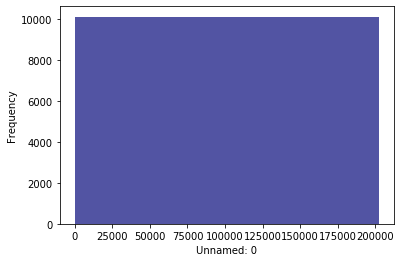

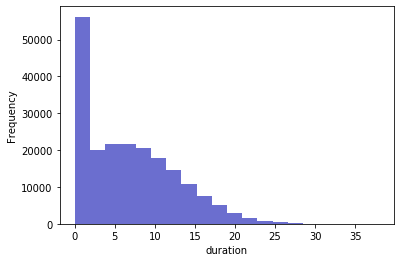

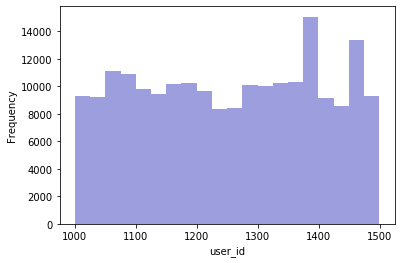

In [42]:
df_graph(calls)

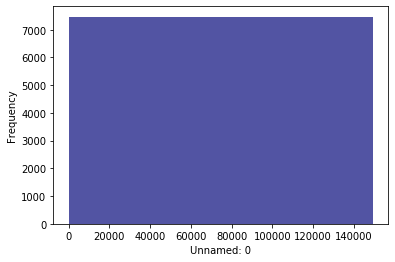

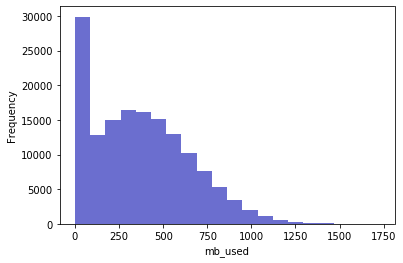

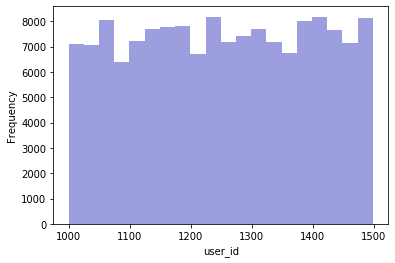

In [43]:
df_graph(internet)

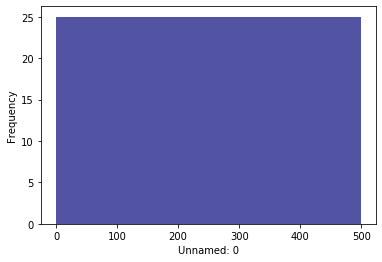

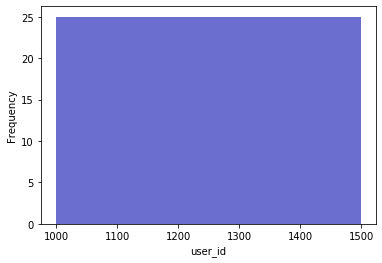

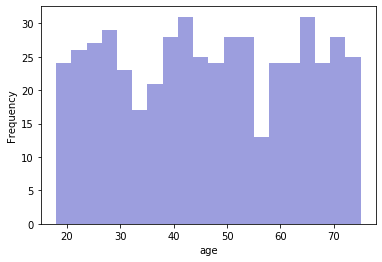

In [44]:
df_graph(users)

В описании задачи говорилось что много звонков с duration= 0, что и видим на графике. Такой же всплеск в районе 0 для mb_used в таблице internet

In [45]:
calls[calls['duration'] == 0].sample(10)

,Unnamed: 0,id,call_date,duration,user_id
182526,182526,1454_278,2018-12-20,0.0,1454
141183,141183,1359_142,2018-09-02,0.0,1359
191186,191186,1470_145,2018-11-09,0.0,1470
115209,115209,1296_22,2018-06-25,0.0,1296
165470,165470,1409_95,2018-12-30,0.0,1409
73631,73631,1185_425,2018-08-21,0.0,1185
166560,166560,1410_195,2018-09-16,0.0,1410
63049,63049,1158_607,2018-08-29,0.0,1158
107568,107568,1277_347,2018-11-05,0.0,1277
70972,70972,1177_152,2018-08-26,0.0,1177


Заполним пропуски в duration медианными значениями того же самого пользователя. Создадим для этого функцию, куда будем передавать датасет, индекс по которому будет происходить объединением, колонку в которой будем заполнять пропуски, массив значений для замены и тип агрегирования

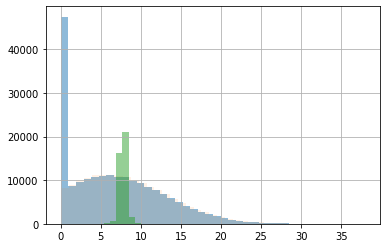

In [46]:
def restore_missed_value_based_on_pivot(df, index_column, value_column, missed_array, aggfunc_type):
    df_pivot = df[~df[value_column].isin(['0', np.nan])].pivot_table(
        index=index_column, 
        values=value_column, 
        aggfunc=aggfunc_type
    )
    df['agg_value'] = df.merge(df_pivot, how='left', left_on=index_column, right_on=index_column).iloc[:,-1]
    df[value_column] = np.where(df[value_column].isin(['0', np.nan]), df['agg_value'], df[value_column])
    #удаляем последний столбец и обновляем индекс
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

calls.duration.hist(bins=40, alpha=0.5)
calls['is_duration0'] = np.where(calls['duration'] == 0, True, False)
restore_missed_value_based_on_pivot(calls, 'user_id', 'duration', ['0', np.nan], 'median')
calls[calls['is_duration0'] == False].duration.hist(bins=39, alpha=0.1)
calls[calls['is_duration0'] == True].duration.hist(bins=6, alpha=0.5)



Получилось не сильно лучше, вместо одного всплеска получился другой. Хорошо бы получить для значений с пропусками такое ж распределение как и для всего датасета. Наше распределение (без учёта 0-ых звонков) похоже на номальное. Посчитаем среднее, дисперсию и стандартное отклонение

In [47]:
calls = pd.read_csv('{}/datasets/calls.csv'.format(path))
calls['is_duration0'] = np.where(calls['duration'] == 0, True, False)

mean_duration = calls[calls['is_duration0'] == False]['duration'].mean()
median_duration = calls[calls['is_duration0'] == False]['duration'].median()
varince_duration = np.var(calls[calls['is_duration0'] == False]['duration'])
stand_dev_duration = np.std(calls[calls['is_duration0'] == False]['duration'])
count_duration = calls[calls['is_duration0'] == True]['duration'].count()

print('Среднее значение:', mean_duration)
print('Медианное значение:', median_duration)
print('Дисперсия:', varince_duration)
print('Стандартное отклонение:', stand_dev_duration)
print('Количество нулевых значений:', count_duration)

Среднее значение: 8.39779402922807
Медианное значение: 7.74
Дисперсия: 28.65466965300041
Стандартное отклонение: 5.353005665324894
Количество нулевых значений: 39613


* Квадрат стандартного отклонения равен дисперсии :)
* Среднее значение 8.4, но оно рассчитано без учёта левого хвоста распределения, которого нет. В этом случае медиана будет лучше описывать среднее значение для "полного" распределения
* По правилу 3-х сигм 99% значений должны быть меньше 7.74+3*5.35=23.79. Судя по графику выше, похоже на правду
* Количество пропущенных значений 39613

Сгенерируем 39613 значений со средним равным 7.74 и стандартным отклонением 5.35

(array([2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 1.200e+01, 2.500e+01,
        3.800e+01, 7.000e+01, 1.290e+02, 2.010e+02, 2.910e+02, 5.210e+02,
        6.800e+02, 9.450e+02, 1.250e+03, 1.665e+03, 2.018e+03, 2.267e+03,
        2.675e+03, 2.964e+03, 2.999e+03, 3.181e+03, 2.987e+03, 2.858e+03,
        2.513e+03, 2.174e+03, 1.868e+03, 1.507e+03, 1.144e+03, 8.730e+02,
        6.210e+02, 4.340e+02, 2.620e+02, 1.730e+02, 1.110e+02, 7.100e+01,
        3.900e+01, 2.100e+01, 9.000e+00, 3.000e+00]),
 array([-14.65824342, -13.60805823, -12.55787303, -11.50768784,
        -10.45750265,  -9.40731745,  -8.35713226,  -7.30694707,
         -6.25676187,  -5.20657668,  -4.15639148,  -3.10620629,
         -2.0560211 ,  -1.0058359 ,   0.04434929,   1.09453448,
          2.14471968,   3.19490487,   4.24509007,   5.29527526,
          6.34546045,   7.39564565,   8.44583084,   9.49601603,
         10.54620123,  11.59638642,  12.64657162,  13.69675681,
         14.746942  ,  15.7971272 ,  16.84731239,  17.

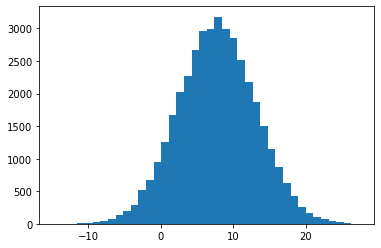

In [48]:
count_duration = calls[calls['is_duration0'] == True]['duration'].count()
random_normal = np.random.normal(median_duration, stand_dev_duration, count_duration)
plot.hist(random_normal, bins=40)

## А ещё лучше сразу сгенерируем распределение ограниченное 0 и 23.79

(array([ 720.,  865.,  971., 1076., 1216., 1288., 1456., 1577., 1677.,
        1677., 1813., 1907., 1929., 1897., 1857., 1882., 1683., 1694.,
        1587., 1440., 1349., 1189., 1085.,  964.,  837.,  741.,  660.,
         529.,  441.,  341.,  316.,  238.,  183.,  155.,  104.,   88.,
          50.,   59.,   43.,   29.]),
 array([1.93401739e-03, 5.96179976e-01, 1.19042593e+00, 1.78467189e+00,
        2.37891785e+00, 2.97316381e+00, 3.56740977e+00, 4.16165573e+00,
        4.75590169e+00, 5.35014765e+00, 5.94439361e+00, 6.53863956e+00,
        7.13288552e+00, 7.72713148e+00, 8.32137744e+00, 8.91562340e+00,
        9.50986936e+00, 1.01041153e+01, 1.06983613e+01, 1.12926072e+01,
        1.18868532e+01, 1.24810992e+01, 1.30753451e+01, 1.36695911e+01,
        1.42638370e+01, 1.48580830e+01, 1.54523289e+01, 1.60465749e+01,
        1.66408209e+01, 1.72350668e+01, 1.78293128e+01, 1.84235587e+01,
        1.90178047e+01, 1.96120507e+01, 2.02062966e+01, 2.08005426e+01,
        2.13947885e+01, 2.1989

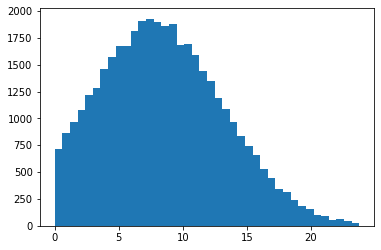

In [49]:
lower, upper = 0, 23.79
mu, sigma = median_duration, stand_dev_duration
random_normal_trunc = st.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
plot.hist(random_normal_trunc.rvs(count_duration), bins=40)

In [50]:
calls.loc[calls['duration'] == 0, 'duration'] = random_normal_trunc.rvs(count_duration)

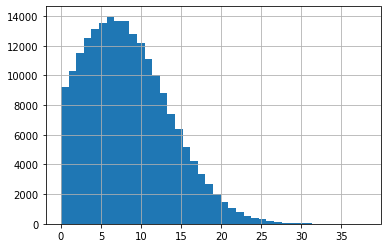

In [51]:
calls.duration.hist(bins=40)

## Ура, получилось!
Сделаем тоже самое для Internet

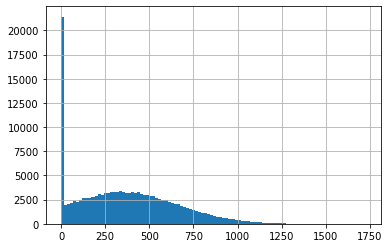

In [52]:
internet.mb_used.hist(bins=100)

In [53]:
internet['mb_used0'] = np.where(internet['mb_used'] == 0, True, False)

mean_mb_used = internet[internet['mb_used0'] == False]['mb_used'].mean()
median_mb_used = internet[internet['mb_used0'] == False]['mb_used'].median()
varince_mb_used = np.var(internet[internet['mb_used0'] == False]['mb_used'])
stand_dev_mb_used = np.std(internet[internet['mb_used0'] == False]['mb_used'])
count_mb_used = internet[internet['mb_used0'] == True]['mb_used'].count()

print('Среднее значение:', mean_mb_used)
print('Медианное значение:', median_mb_used)
print('Дисперсия:', varince_mb_used)
print('Стандартное отклонение:', stand_dev_mb_used)
print('Количество нулевых значений:', count_mb_used)

Среднее значение: 426.08721035763267
Медианное значение: 400.54
Дисперсия: 65329.040565885436
Стандартное отклонение: 255.59546272554493
Количество нулевых значений: 19598


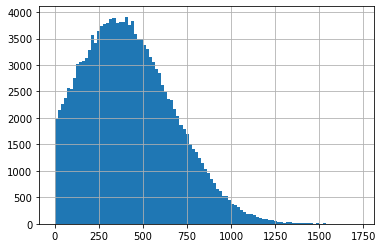

In [54]:
lower, upper = 0, 1166.8
mu, sigma = median_mb_used, stand_dev_mb_used
random_normal_trunc = st.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

internet.loc[internet['mb_used'] == 0, 'mb_used'] = random_normal_trunc.rvs(count_mb_used)
internet.mb_used.hist(bins=100)

## Пропущенные значения заполнены
Посмотрим количество сделанных звонков и израсходованных минут разговора по месяцам

In [55]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_agg = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_agg.columns = ['user_id', 'month', 'count_calls', 'sum_duration']
calls_agg.head()

,user_id,month,count_calls,sum_duration
0,1000,5,22,206.593080
1,1000,6,43,306.372882
2,1000,7,47,375.236673
3,1000,8,52,482.247591
4,1000,9,58,568.781987


Количество отправленных сообщений по месяцам

In [56]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_agg = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc=['count']).reset_index()
messages_agg.columns = ['user_id', 'month', 'count_messages']
messages_agg.head()

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Объем израсходованного интернет-трафика по месяцам

In [57]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_agg = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum']).reset_index()
internet_agg.columns = ['user_id', 'month', 'sum_mb_used']
internet_agg.head()

,user_id,month,sum_mb_used
0,1000,5,2353.283527
1,1000,6,25482.344232
2,1000,7,14065.069291
3,1000,8,15569.187996
4,1000,9,15409.709846


Собирём все данные в одну таблицу

In [58]:
bigdata = pd.concat([calls[['user_id', 'month']], messages[['user_id', 'month']], internet[['user_id', 'month']]])
bigdata = bigdata.drop_duplicates().reset_index(drop=True)
    #df['agg_value'] = df.merge(df_pivot, how='left', left_on=index_column, right_on=index_column).iloc[:,-1]
    #df[value_column] = np.where(df[value_column].isin(['0', np.nan]), df['agg_value'], df[value_column])
bigdata = bigdata.merge(calls_agg, how='left', left_on=['user_id', 'month'], right_on=['user_id', 'month'])
bigdata = bigdata.merge(messages_agg, how='left', left_on=['user_id', 'month'], right_on=['user_id', 'month'])
bigdata = bigdata.merge(internet_agg, how='left', left_on=['user_id', 'month'], right_on=['user_id', 'month'])
bigdata = bigdata.merge(users[['user_id', 'age', 'reg_date', 'churn_date', 'city', 'tariff']], how='left', left_on=['user_id'], right_on=['user_id'])
bigdata = bigdata.merge(tariffs, how='left', left_on=['tariff'], right_on=['tariff_name'])
bigdata.head()

,user_id,month,count_calls,sum_duration,count_messages,sum_mb_used,age,reg_date,churn_date,city,tariff,Unnamed: 0,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,7,47.0,375.236673,75.0,14065.069291,52,2018-05-25,NaT,Краснодар,ultra,1,1000,30720,3000,1950,150,1,1,ultra
1,1000,8,52.0,482.247591,81.0,15569.187996,52,2018-05-25,NaT,Краснодар,ultra,1,1000,30720,3000,1950,150,1,1,ultra
2,1000,6,43.0,306.372882,60.0,25482.344232,52,2018-05-25,NaT,Краснодар,ultra,1,1000,30720,3000,1950,150,1,1,ultra
3,1000,9,58.0,568.781987,57.0,15409.709846,52,2018-05-25,NaT,Краснодар,ultra,1,1000,30720,3000,1950,150,1,1,ultra
4,1000,12,46.0,366.990012,70.0,10497.171686,52,2018-05-25,NaT,Краснодар,ultra,1,1000,30720,3000,1950,150,1,1,ultra


Посчитаем помесячную выручку с каждого пользователя

In [59]:
def income_calc(row):
    total_fee = 0
    monthly_fee = row['rub_monthly_fee']
    minutes_fee = 0
    if row['sum_duration'] > row['minutes_included']:
        minutes_fee = math.ceil(row['sum_duration'] - row['minutes_included'])*row['rub_per_minute']
    messages_fee = 0
    if row['count_messages'] > row['messages_included']:
        minutes_fee = (row['count_messages'] - row['messages_included'])*row['rub_per_message']
    internet_fee = 0
    if row['sum_mb_used'] > row['mg_per_month_included']:
        minutes_fee = math.ceil((row['sum_mb_used'] - row['mg_per_month_included'])/1024)*row['rub_per_gb']
    total_fee = monthly_fee + minutes_fee + messages_fee + internet_fee
    return total_fee

bigdata['income'] = bigdata.apply(income_calc, axis=1)

In [60]:
bigdata.head()

,user_id,month,count_calls,sum_duration,count_messages,sum_mb_used,age,reg_date,churn_date,city,...,Unnamed: 0,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,income
0,1000,7,47.0,375.236673,75.0,14065.069291,52,2018-05-25,NaT,Краснодар,...,1,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,8,52.0,482.247591,81.0,15569.187996,52,2018-05-25,NaT,Краснодар,...,1,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,6,43.0,306.372882,60.0,25482.344232,52,2018-05-25,NaT,Краснодар,...,1,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,9,58.0,568.781987,57.0,15409.709846,52,2018-05-25,NaT,Краснодар,...,1,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,12,46.0,366.990012,70.0,10497.171686,52,2018-05-25,NaT,Краснодар,...,1,1000,30720,3000,1950,150,1,1,ultra,1950.0


## Проанализируем данные

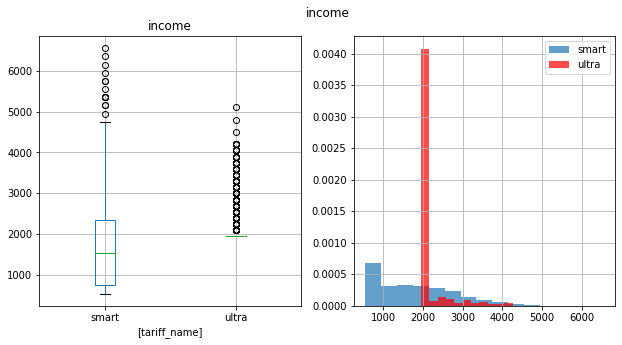

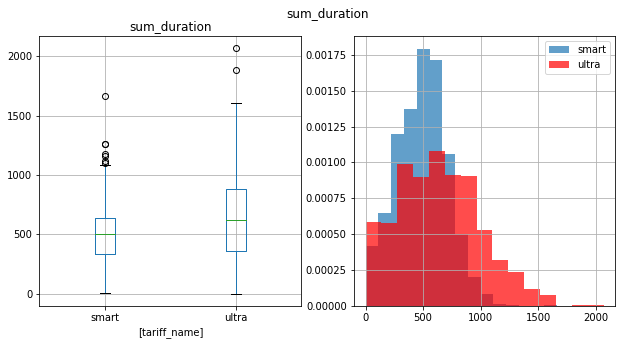

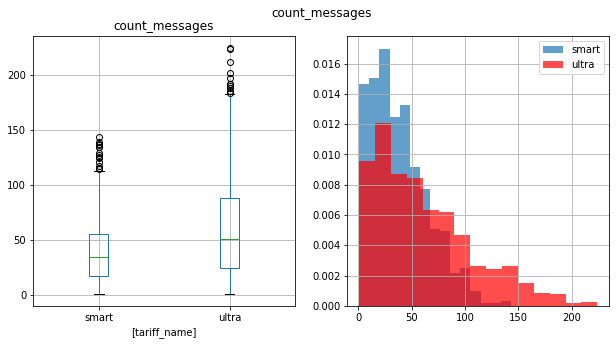

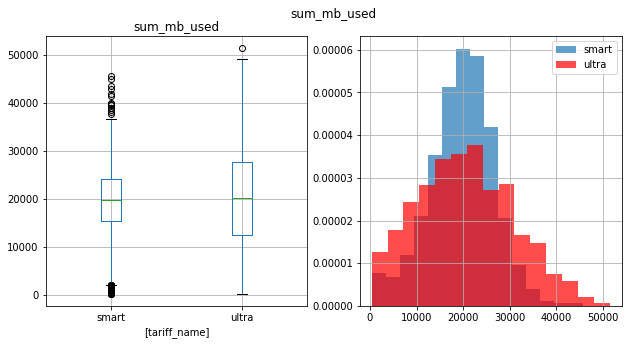

In [61]:
graph=['income', 'sum_duration', 'count_messages',  'sum_mb_used']

for y in graph:
    fig, (ax1, ax2) = plot.subplots(1, 2, figsize=(10, 5))
    bigdata[['tariff_name', y]].boxplot(by='tariff_name', ax=ax1)
    bigdata.query('tariff_name == "smart"')[y].hist(bins=15, ax=ax2, alpha=.7, label='smart', density=1)
    bigdata.query('tariff_name == "ultra"')[y].hist(bins=15, ax=ax2, color='Red', alpha=.7, label='ultra', density=1)
    ax2.legend(prop={'size': 10})
    fig.suptitle(y)
#     ax1.suptitle('')
#    ax1.title('')

* На тарифе ultra почти все пользователи платят только абонентскую плату. Никто из них не доходит до порога по минутам или СМС. Есть категория пользователей, которым нужно больше 30Гб в месяц
* На тарифе smart только половине пользователей хватает 500минут в месяц. Четверти не хватает 50 СМС. И 3\4 не хватает 15Гб


In [62]:
print('                          --====================SMART====================--')
print('MEAN')
print(np.mean(bigdata.query('tariff_name == "smart"')[['sum_duration', 'count_messages', 'sum_mb_used']]))
print()
print('VAR')
print(np.var(bigdata.query('tariff_name == "smart"')[['sum_duration', 'count_messages', 'sum_mb_used']]))
print()
print('STD')
print(np.std(bigdata.query('tariff_name == "smart"')[['sum_duration', 'count_messages', 'sum_mb_used']]))
print()
print('                          --====================ULTRA====================--')
print('MEAN')
print(np.mean(bigdata.query('tariff_name == "ultra"')[['sum_duration', 'count_messages', 'sum_mb_used']]))
print()
print('VAR')
print(np.var(bigdata.query('tariff_name == "ultra"')[['sum_duration', 'count_messages', 'sum_mb_used']]))
print()
print('STD')
print(np.std(bigdata.query('tariff_name == "ultra"')[['sum_duration', 'count_messages', 'sum_mb_used']]))


--====================SMART====================--
MEAN
sum_duration        493.857403
count_messages       38.716441
sum_mb_used       19652.200434
dtype: float64

VAR
sum_duration      4.852316e+04
count_messages    7.172208e+02
sum_mb_used       4.862736e+07
dtype: float64

STD
sum_duration       220.279738
count_messages      26.780979
sum_mb_used       6973.331748
dtype: float64

                          --====================ULTRA====================--
MEAN
sum_duration        640.430187
count_messages       61.161006
sum_mb_used       20451.752102
dtype: float64

VAR
sum_duration      1.289201e+05
count_messages    2.107006e+03
sum_mb_used       1.059514e+08
dtype: float64

STD
sum_duration        359.054451
count_messages       45.902130
sum_mb_used       10293.271726
dtype: float64


## Проверим гипотезу 1
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза звучит как "средняя выручка на тарифе Ультра равна средней выручке на тарифе Смарт". Если пороговое значение окажется меньше 0.05, будем считать что H0 подтвердилась
В данном случае мы сравниваем две генеральные совокупности<br>
Для начала посчитаем среднее значение выручки на одного пользователя в месяц

In [63]:
bigdata_month = bigdata.pivot_table(index=['tariff_name', 'month'], values='income').reset_index()
bigdata_month

,tariff_name,month,income
0,smart,1,840.352941
1,smart,2,1133.068966
2,smart,3,1506.168831
3,smart,4,1280.651786
4,smart,5,1638.042553
5,smart,6,1640.914634
6,smart,7,1652.323383
7,smart,8,1757.625532
8,smart,9,1672.423077
9,smart,10,1841.367347


In [64]:
alpha = .05
results = st.ttest_ind(
    bigdata_month.query('tariff_name == "smart"')['income'], 
    bigdata_month.query('tariff_name == "ultra"')['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.1877518149105334e-05
Отвергаем нулевую гипотезу


p-значение очень маленькое, мы отвергаем H0. Средняя выручка с тарифов различается 

## Проверим гипотезу 2
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов<br>
Проверим гипотезу 2 для каждого тарифа в отдельности<br>
H0 звучит как "средняя выручка пользователей из Москвы равна выручке пользователй из других регионов"

In [65]:
bigdata['is_moscow'] = np.where(bigdata['city'] == 'Москва', True, False)
bigdata_month_city = bigdata.pivot_table(index=['tariff_name', 'month', 'is_moscow'], values='income').reset_index()
bigdata_month_city.head()

,tariff_name,month,is_moscow,income
0,smart,1,False,779.066667
1,smart,1,True,1300.000000
2,smart,2,False,1157.857143
3,smart,2,True,998.111111
4,smart,3,False,1441.287879


In [66]:
alpha = .05
results = st.ttest_ind(
    bigdata_month_city.query('tariff_name == "smart" and is_moscow == True')['income'], 
    bigdata_month_city.query('tariff_name == "smart" and is_moscow == False')['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.817274322293359
Не получилось отвергнуть нулевую гипотезу


In [67]:
alpha = .05
results = st.ttest_ind(
    bigdata_month_city.query('tariff_name == "ultra" and is_moscow == True')['income'], 
    bigdata_month_city.query('tariff_name == "ultra" and is_moscow == False')['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.2933161809175062
Не получилось отвергнуть нулевую гипотезу


В обоих случаях не получилось отвергнуть нулевую гипотезу. Значит выручка пользователей из Москвы и регионов на одних и тех же тарифах отличается не так уж сильно.<br>
Проверим сможем ли мы отвергнуть H0 если не будем делить выборку по тарифам

In [68]:
bigdata_month_city = bigdata.pivot_table(index=['month', 'is_moscow'], values='income').reset_index()
bigdata_month_city.head()

,month,is_moscow,income
0,1,False,946.342857
1,1,True,1625.000000
2,2,False,1388.014706
3,2,True,1391.642857
4,3,False,1615.159574


In [69]:
alpha = .05
results = st.ttest_ind(
    bigdata_month_city.query('is_moscow == True')['income'], 
    bigdata_month_city.query('is_moscow == False')['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3772895288934528
Не получилось отвергнуть нулевую гипотезу


Результат такой же

## В пересчёте на одного пользователя тариф Ультра значительно выгоднее для Мегалайна
### Зависимости средней выручки от региона нет
### Для понимания какой тариф в целом выгоднее для Мегалайна нужно знать сколько абонентов пользуется каждым тарифом